<a href="https://colab.research.google.com/github/Yuxuan-Zhang-Dexter/GNN_demo/blob/main/introduction_to_gnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA of KarateClub Graph Dataset

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.0 MB/s eta 0:00:00


In [2]:
# set up the environment and import necessary packages
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# import KarateClub dataset, a social network
from torch_geometric.datasets import KarateClub

# Import dataset from PyTorch Geometric
dataset = KarateClub()

# Print information
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print first element
print(f'Graph: {dataset[0]}')

data = dataset[0]

# this is just an identity matrix, nothing important
print(f'x = {data.x.shape}')
print(data.x)

KarateClub()
------------
Number of graphs: 1
Number of features: 34
Number of classes: 4
Graph: Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
x = torch.Size([34, 34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [4]:
# a coordinate list (COO format) efficiently stores a sparse matrix. The first list stores node and the second list stores destination node
print(f'edge_index = {data.edge_index.shape}')
print(data.edge_index)

# an adjacent matrix A, a square matrix, store the connectivity between each node
from torch_geometric.utils import to_dense_adj

A = to_dense_adj(data.edge_index)[0].numpy().astype(int)
print(f'A = {A.shape}')
print(A)

# ground-truth label
print(f'y = {data.y.shape}')
print(data.y)

edge_index = torch.Size([2, 156])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3, 

In [5]:
# The train mask shows which nodes are supposed to be used for training with True statements.
print(f'train_mask = {data.train_mask.shape}')
print(data.train_mask)


# check direction; nodes not connected with rest of graph; self-loop nodes
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

train_mask = torch.Size([34])
tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


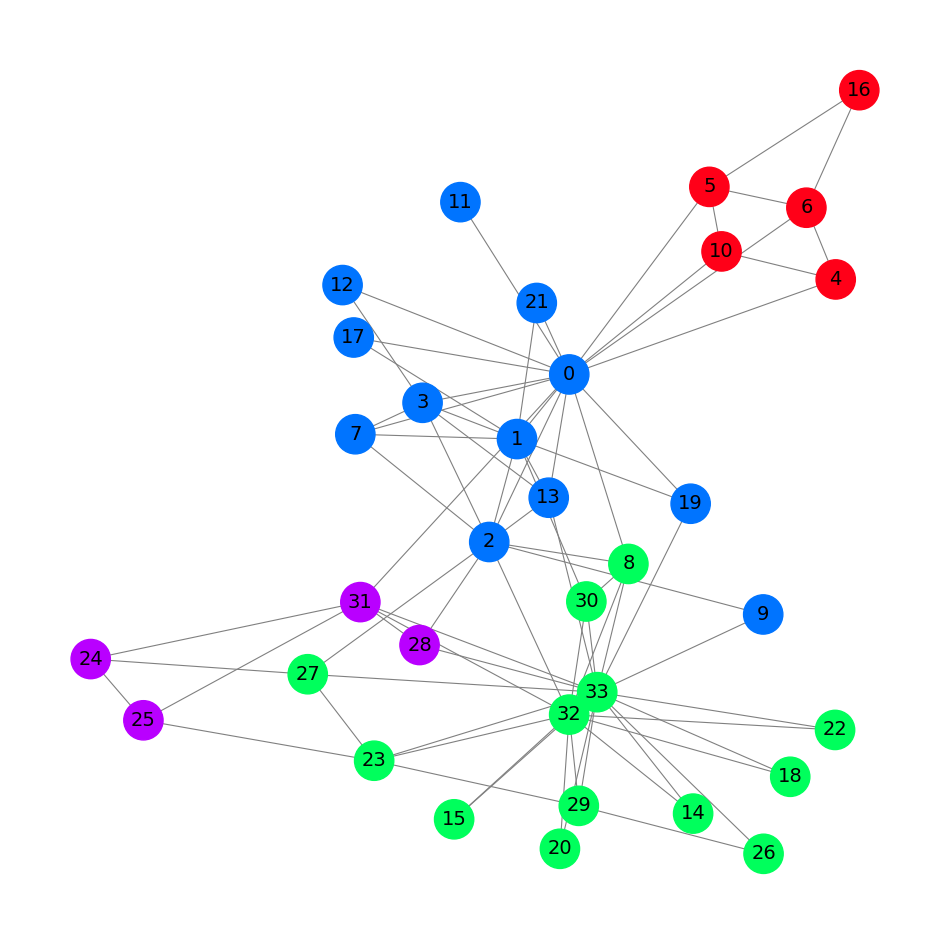

In [6]:
# visualize graph dataset using networkx
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

# Build Graph Convolutional Network

In the graph convolution operation,

$$
h_i = \sum_{j \in \mathcal{N}_i} \frac{1}{\sqrt{\text{deg}(i)} \sqrt{\text{deg}(j)}} W x_j
$$

we are aggregating features from the neighbors $( \mathcal{N}_i )$ of a node $( i )$.

- $( x_j )$ represents the 34-dimensional feature vector for each node $( j )$, indicating the node's connections with other nodes in the graph.
- $( W )$ is a transformation matrix of dimensions $( 3 \times 34 )$.
- $( \text{deg}(i) )$ denotes the degree of node $( i )$, the number of neighbors it has, and $( \sqrt{\text{deg}(i)} )$ serves to normalize the node's features, balancing the effect between nodes with varying numbers of neighbors.
- Similarly, $( \sqrt{\text{deg}(j)} )$ normalizes the influence of each neighbor $( j )$, giving more significance to those with fewer connections.

**Assumption**: We consider every node and its connections to hold equal importance in the graph.

**Implementation Details**:

1. **Vector Transformation**: The feature vector $( x_j )$ for each node is transformed by the weight matrix $( W )$, projecting from a 34-dimensional space to a 3-dimensional space, resulting in the hidden representation $( h_i )$.

2. **Activation Function**: A ReLU (Rectified Linear Unit) activation function is applied to the 3-dimensional representation $( h_i )$ to introduce non-linearity into the model.

3. **Output Projection**: The 3-dimensional hidden representation $( h_i )$ is then projected onto a 4-dimensional output space $( z )$ using additional learnable parameters (not explicitly detailed here).

4. **Classification**: The classification is determined by selecting the index of the maximum value in the output vector $( z )$, which represents the model's prediction.

With 34 nodes, this process is replicated for each node, leveraging the graph structure and feature information to perform the classification task.


In [9]:
# “Semi-supervised Classification with Graph Convolutional Networks” algorithm for gcn; project 34 to 3 and relu to classification
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 3)
        self.out = Linear(3, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z

model = GCN()
print(model)

GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)


In [18]:
# training part
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []

# Training loop
for epoch in range(201):
    # Clear gradients
    optimizer.zero_grad()

    # Forward pass
    h, z = model(data.x, data.edge_index)

    # Calculate loss function
    loss = criterion(z, data.y)
    print(f'z is {z}')

    # Calculate accuracy
    acc = accuracy(z.argmax(dim=1), data.y)

    # Compute gradients
    loss.backward()

    # Tune parameters
    optimizer.step()

    # Store data for animations
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))

    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

Streaming output truncated to the last 5000 lines.
        [ 10.6789, -10.6879,  -7.9041,  -8.8467],
        [ -6.8908,  -2.4931,  15.8154, -29.3154],
        [ 28.9500, -25.4480,  -7.8511, -12.3263],
        [ 23.7598, -20.4784, -10.9444,  -8.2594]], grad_fn=<AddmmBackward0>)
z is tensor([[-22.2934,  19.7396, -24.5225,   1.9952],
        [-21.4756,  16.3742, -13.8843, -10.0026],
        [-13.2427,   8.6316,  -9.3344, -13.4316],
        [-21.8228,  16.1000, -11.6259, -11.6166],
        [  1.6194,   1.9530, -29.0786,  19.9082],
        [  1.6094,   2.4504, -31.0271,  21.8166],
        [  1.6522,   2.5334, -31.5109,  22.1149],
        [-15.5397,  10.9129, -10.8723,  -9.8657],
        [ 12.0258, -11.7314,  -8.7140,  -8.7274],
        [-11.2347,   7.1985,  -9.8300, -10.4154],
        [  1.5445,   1.8405, -28.3614,  19.5283],
        [-16.0389,  10.6586,  -8.1089, -10.9011],
        [-16.7940,  11.1515,  -7.6369, -11.1926],
        [-12.1595,   8.0974, -10.4932, -10.2727],
        [ 14.3118

In [11]:
# visualize the training part
%%capture
from IPython.display import HTML
from matplotlib import animation
plt.rcParams["animation.bitrate"] = 3000

def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=800,
                    node_color=outputs[i],
                    cmap="hsv",
                    vmin=-2,
                    vmax=3,
                    width=0.8,
                    edge_color="grey",
                    font_size=14
                    )
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=20)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')

anim = animation.FuncAnimation(fig, animate, \
            np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())

In [12]:
display(html)

In [13]:
# Print embeddings
print(f'Final embeddings = {h.shape}')
print(h)

Final embeddings = torch.Size([34, 3])
tensor([[3.6127, 2.4685, 0.7743],
        [2.7665, 2.8888, 1.3814],
        [1.9128, 2.4295, 1.5402],
        [2.7002, 3.0985, 1.2940],
        [2.8702, 0.1033, 0.3859],
        [2.8607, 0.0000, 0.0515],
        [2.9443, 0.0000, 0.1953],
        [2.2952, 2.5554, 1.2767],
        [1.1620, 0.4238, 2.7828],
        [1.8938, 2.1443, 1.4417],
        [2.7368, 0.0866, 0.3690],
        [2.1189, 2.5286, 1.3536],
        [2.2141, 2.5126, 1.3319],
        [2.1479, 2.3071, 1.5307],
        [0.9616, 0.1061, 2.9386],
        [1.0569, 0.1686, 2.9390],
        [2.6085, 0.0000, 0.3009],
        [2.1504, 2.3754, 1.2416],
        [0.9249, 0.0584, 2.7419],
        [1.9888, 2.0682, 1.3009],
        [0.9321, 0.0650, 2.8461],
        [2.0828, 2.3499, 1.2131],
        [0.9466, 0.0800, 2.8212],
        [0.6150, 0.0894, 2.9613],
        [0.0000, 1.6722, 1.7604],
        [0.0000, 1.6326, 1.6539],
        [1.2669, 0.0000, 3.0837],
        [0.8299, 0.7372, 2.8301],
        [

In [14]:
# animate how the embeddings change every epoch
%%capture

def animate(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=40)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')
ax = fig.add_subplot(projection='3d')
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

anim = animation.FuncAnimation(fig, animate, \
              np.arange(0, 200, 10), interval=800, repeat=True)
html = HTML(anim.to_html5_video())

In [15]:
display(html)